In [ ]:
!pip install statsmodels

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=80c5616a8792bd955805c767b8940a2849a9fcf3b7fc4009c2484cc0b2428e26
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def plot(df, field, label):
  plt.figure(figsize=(6, 4))
  df['date'] = pd.to_datetime(df['date'])
  plt.plot(df['date'], df[field], linestyle='-',label='Wheat Prices')
  plt.title(label)
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  print("\n\n")


In [ ]:
df = pd.read_csv("modal_uttar_pradesh.csv")
print(df)

            date  modal_price
0     2005-08-26        680.0
1     2005-08-27        685.0
2     2005-08-28        687.5
3     2005-08-29        690.0
4     2005-08-30        690.0
...          ...          ...
6646  2023-11-06       2500.0
6647  2023-11-07       2510.0
6648  2023-11-08       2510.0
6649  2023-11-09       2500.0
6650  2023-11-10       2500.0

[6651 rows x 2 columns]


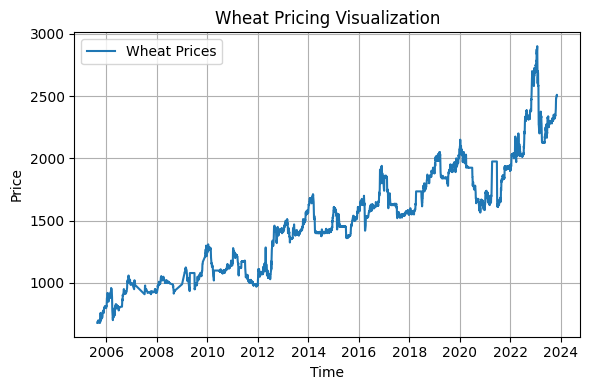

In [ ]:
plot(df, "modal_price", "Wheat Pricing Visualization")

In [ ]:
result = adfuller(df['modal_price'])

# print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.0222708875343163
p-value: 0.7450550950788697


P is not <= 0.05, time series is not stationary

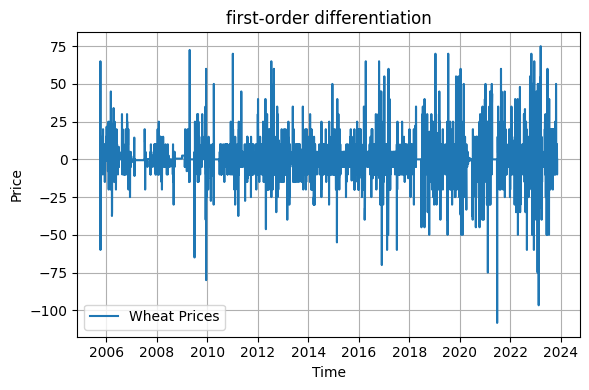

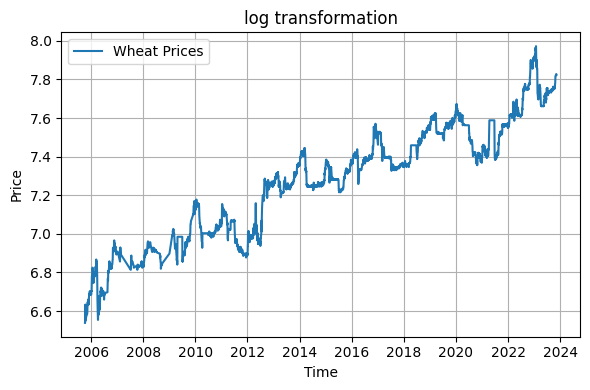

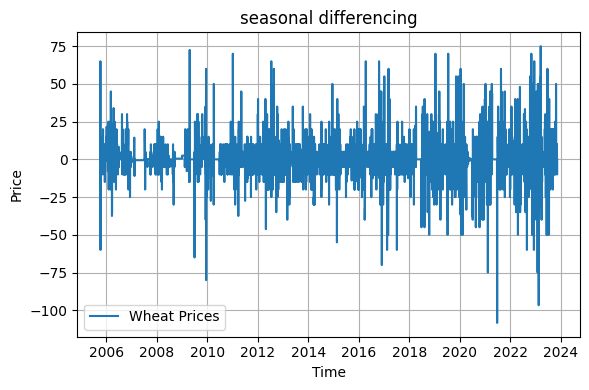

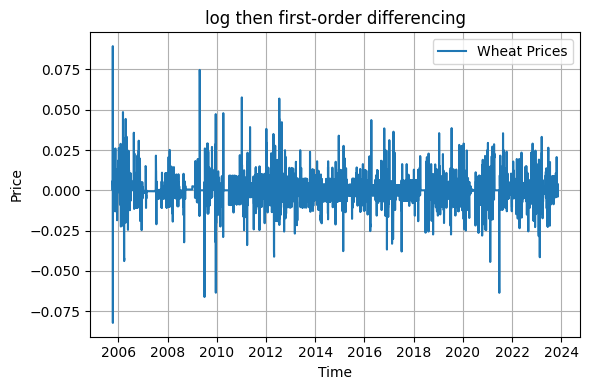

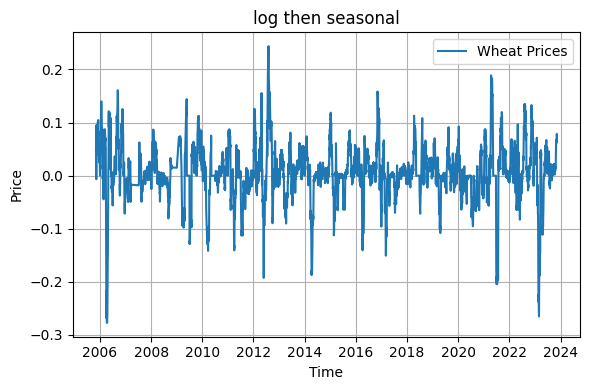

In [ ]:
df['modal_price'].fillna(method='ffill', inplace=True)

# 1. first-order differencing
df['modal_price_diff_1'] = df['modal_price'].diff(1)

# 2. log transformation
df['modal_price_log'] = np.log(df['modal_price'])

# 3. seasonal differencing (assuming a monthly seasonality)
df['modal_price_diff_seasonal'] = df['modal_price'].diff(1)

# 4. log transformation followed by first-order differencing
df['modal_price_log_diff_1'] = df['modal_price_log'].diff(1)

# 5. log transformation followed by seasonal differencing
df['modal_price_log_diff_seasonal'] = df['modal_price_log'].diff(30)

plot(df, "modal_price_diff_1", "first-order differentiation")
plot(df, "modal_price_log", "log transformation")
plot(df, "modal_price_diff_seasonal", "seasonal differencing")
plot(df, "modal_price_log_diff_1", "log then first-order differencing")
plot(df, "modal_price_log_diff_seasonal", "log then seasonal")
# result = adfuller(df['modal_price'])
# print('p-value:', result[1])


Use log then seasonal for ARIMA

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)
result = adfuller(df['modal_price_log_diff_seasonal'])

# print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -9.156225735174722
p-value: 2.605430754293999e-15


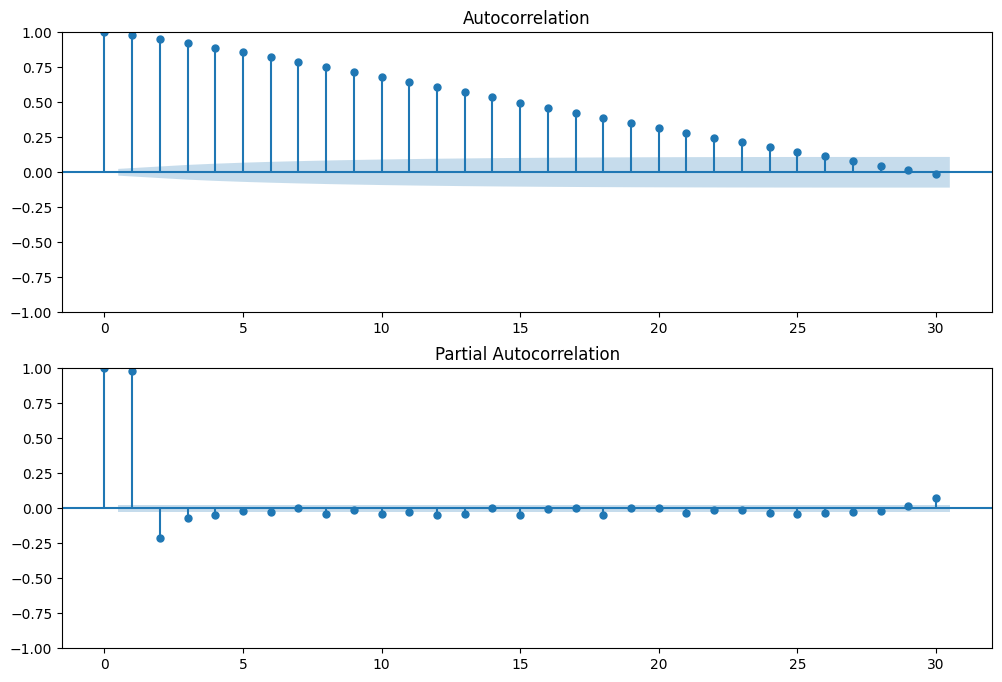

In [ ]:
# plot ACF and PACF to determine ARIMA parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['modal_price_log_diff_seasonal'],  lags=30, ax=ax1)
plot_pacf(df['modal_price_log_diff_seasonal'], lags=30, ax=ax2)
plt.show()

Split into train and test

In [ ]:
print(len())

6621


In [ ]:
train = pd.DataFrame(df.iloc[:int(len(df)*0.9)])
test = pd.DataFrame(df.iloc[int(len(df)*0.9):])

print(train,test)

           date  modal_price  modal_price_diff_1  modal_price_log  \
0    2005-11-05        725.0            0.714286         6.586172   
1    2005-11-06        725.0            0.000000         6.586172   
2    2005-11-07        725.0            0.000000         6.586172   
3    2005-11-08        737.5           12.500000         6.603266   
4    2005-11-09        750.0           12.500000         6.620073   
...         ...          ...                 ...              ...   
5917 2022-01-17       1940.0            2.500000         7.570443   
5918 2022-01-18       1975.0           35.000000         7.588324   
5919 2022-01-19       1985.0           10.000000         7.593374   
5920 2022-01-20       2000.0           15.000000         7.600902   
5921 2022-01-21       2025.0           25.000000         7.613325   

      modal_price_diff_seasonal  modal_price_log_diff_1  \
0                      0.714286                0.000986   
1                      0.000000                0.0000

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

order = (2, 0, 0)  #(p, d, q) where p is from PACF, q is from ACF
model = ARIMA(train['modal_price_log_diff_seasonal'], order=order)
results = model.fit()

# Summary of the ARIMA model
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:     modal_price_log_diff_seasonal   No. Observations:                 5922
Model:                            ARIMA(2, 0, 0)   Log Likelihood               18835.997
Date:                           Wed, 15 Nov 2023   AIC                         -37663.993
Time:                                   23:35:31   BIC                         -37637.247
Sample:                                        0   HQIC                        -37654.699
                                          - 5922                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.006      0.906      0.365      -0.006       0.016
ar.L1          1.1786      0.006    200.055

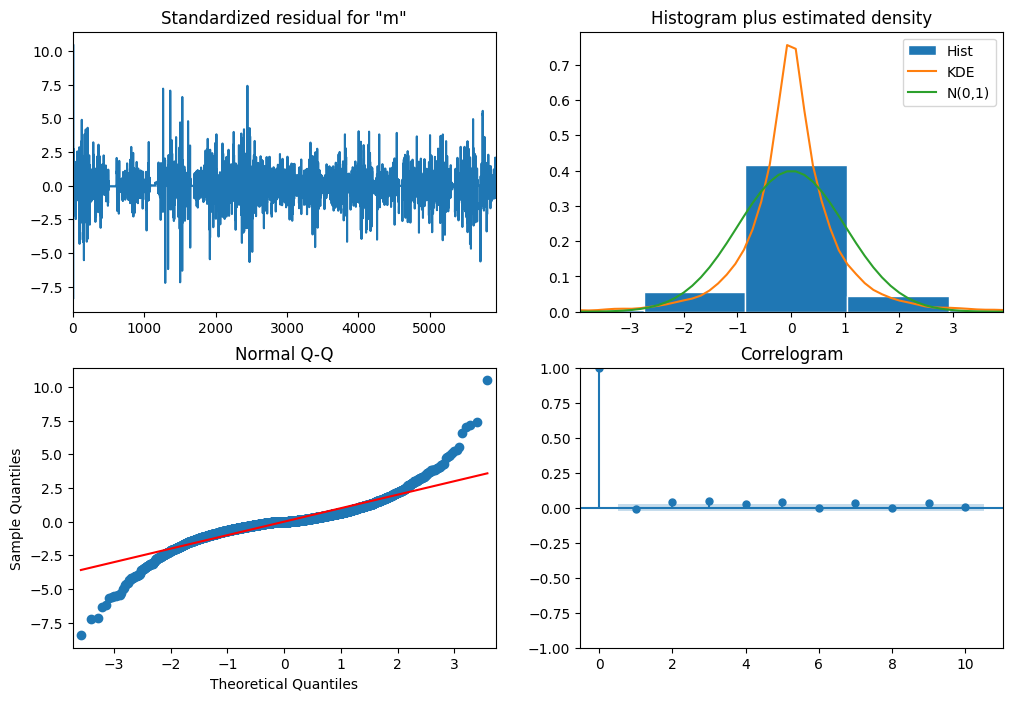

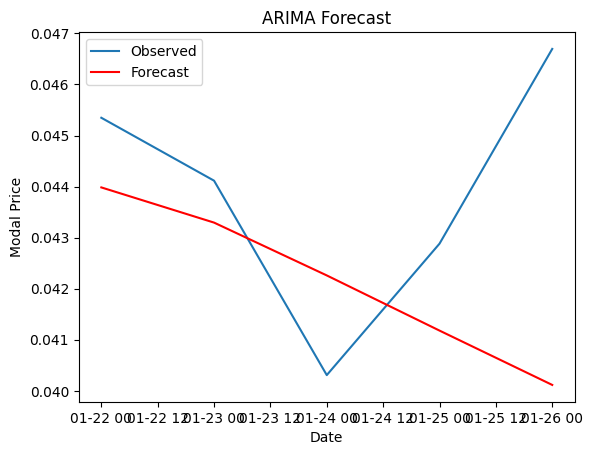

In [ ]:
# Plot the residuals
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast future values
forecast_steps = 5  # Example, adjust based on your needs
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(train.iloc[-1]["date"], periods=forecast_steps + 1, freq='D')[1:]
forecast_mean = forecast.predicted_mean


plt.plot(test.iloc[:forecast_steps]["date"], test.iloc[:forecast_steps]['modal_price_log_diff_seasonal'], label='Observed')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Modal Price')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()